In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from transformers import LlamaForCausalLM, LlamaTokenizer, pipeline
from tqdm.auto import tqdm
import json
import os
from huggingface_hub import login
from joblib import Parallel, delayed
import multiprocessing


In [126]:
data_cleaned = pd.read_csv('Madrid_reviews_cleaned.csv')

In [127]:
data_cleaned['clean_text'] = data_cleaned['clean_text'].astype(str) 

In [128]:
data_cleaned['review_full'] = data_cleaned['review_full'].astype(str) 

# bart-large-mnli

### Predicting Labels

### Evaluate Predictions

In [95]:
def convert_label_to_rating(label):
    label_to_rating = {
        "very bad": 1,
        "bad": 2,
        "average": 3,
        "good": 4,
        "very good": 5
    }
    return label_to_rating[label]

In [96]:
# Specify the path to your Parquet file
parquet_file = 'classified_reviews_bart-large-mnli.parquet'

# Use pandas to read the Parquet file
bart_df = pd.read_parquet(parquet_file)

bart_df['predicted_rating'] = bart_df['predicted_label'].apply(convert_label_to_rating)

bart_df.head()


,Unnamed: 0,parse_count,restaurant_name,rating_review,sample,review_id,title_review,review_preview,review_full,date,...,emotion_negative,emotion_sadness,word_count,unique_word_count,mean_word_length,hashtag_count,mention_count,clean_text,predicted_label,predicted_rating
0,61198,61199,Cinco_Jotas_Jorge_Juan,3,Negative,review_453804271,Average but must be great in summer,I ate here on a Monday night in the middle of ...,I ate here on a Monday night in the middle of ...,2017-01-21,...,0.166667,0.166667,72,57,3.958333,0,0,ate monday night middl winter hardli anyon els...,bad,2
1,51476,51477,127_Taipei_Bar_Ramen_Baos,5,Positive,review_621494959,The Best meal EVER,"The food is excellent, authentic, and in my op...","The food is excellent, authentic, and in my op...",2018-10-02,...,0.000000,0.000000,29,26,4.551724,0,0,food excel authent opinion best meal ever eate...,very good,5
2,114722,114723,Taberna_Antonio_Sanchez,5,Positive,review_696707542,Our local,We did not eat here but we were delighted to c...,We did not eat here but we were delighted to c...,2019-08-07,...,0.000000,0.000000,44,37,3.772727,0,0,eat delight call local stay madrid much short ...,good,4
3,58768,58769,Mercado_de_San_Miguel,5,Positive,review_698222961,An interesting place,This place is a must if you are in Madrid.The ...,This place is a must if you are in Madrid.The ...,2019-08-12,...,0.142857,0.000000,31,26,4.387097,0,0,place must madrid combin food flavour smell mi...,good,4
4,160266,160267,La_Central_de_Callao,5,Positive,review_213696024,"Bookstore, art gallery & food",Loved this cafe! Hungry after arriving in Madr...,Loved this cafe! Hungry after arriving in Madr...,2014-07-04,...,0.076923,0.076923,44,39,4.954545,0,0,love cafe hungri arriv madrid wander citi see ...,good,4


In [97]:
bart_df['predicted_rating'].value_counts().sort_index()
percent_of_total = bart_df['predicted_rating'].value_counts(normalize=True).sort_index() 
percent_of_total

predicted_rating
1    0.005656
2    0.112557
3    0.007919
4    0.484163
5    0.389706
Name: proportion, dtype: float64

In [98]:
bart_df['rating_diff']=bart_df['predicted_rating']-bart_df['rating_review']

In [99]:
bart_df['rating_diff'].value_counts().sort_index()
percent_of_total = bart_df['rating_diff'].value_counts(normalize=True).sort_index() 
percent_of_total

rating_diff
-3    0.026584
-2    0.016968
-1    0.259050
 0    0.489819
 1    0.169118
 2    0.028281
 3    0.009615
 4    0.000566
Name: proportion, dtype: float64

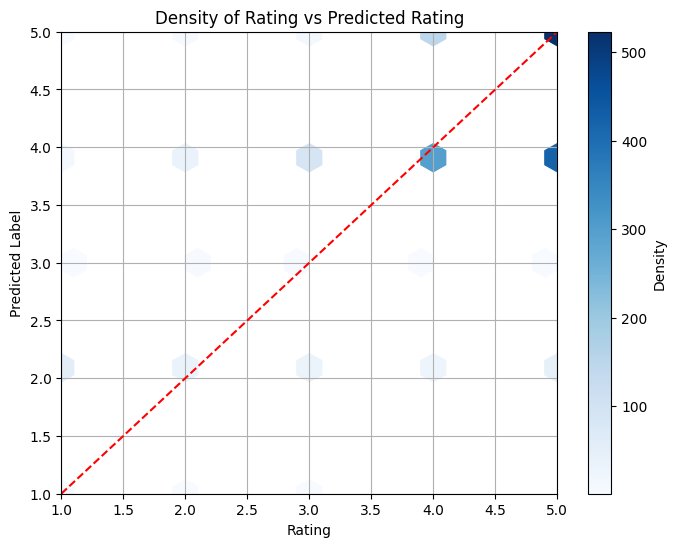

In [100]:
# Create a hexbin plot to show density
plt.figure(figsize=(8, 6))
plt.hexbin(bart_df['rating_review'], bart_df['predicted_rating'], gridsize=20, cmap='Blues', mincnt=1)
plt.plot([1, 5], [1, 5], color='red', linestyle='--')  # Adding a diagonal line for reference

plt.title('Density of Rating vs Predicted Rating')
plt.xlabel('Rating')
plt.ylabel('Predicted Label')
plt.xlim(1, 5)
plt.ylim(1, 5)
plt.colorbar(label='Density')
plt.grid(True)
plt.show()

# Llama2

### Create Predicitions

# RoBERTa

### Create Predictions

In [131]:
import pandas as pd
from transformers import pipeline
from tqdm import tqdm
import concurrent.futures
import psutil
import os

# Define the zero-shot classification pipeline using RoBERTa
classifier = pipeline("zero-shot-classification", model="roberta-large-mnli")

# Define the labels for classification
labels = ["very bad review", "bad review", "average review", "good review", "very good review"]

# Function to classify a single piece of text
def classify_text(text):
    result = classifier(text, labels)
    return result['labels'][0]  # The label with the highest score

# Check available memory
def get_available_memory():
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    return mem_info.rss / (1024 ** 2)  # Return memory usage in MB

# Assuming `data_cleaned` is your DataFrame with a column 'clean_text'
# Define chunk size
chunk_size = 1000  # Adjust as needed

# Number of threads to use (adjust as needed)
num_threads = 3  # Use a small number of threads to limit CPU usage

# Wrap your pandas apply with tqdm for a progress bar
tqdm.pandas()

# Function to classify text in parallel
def parallel_classify_texts(texts, num_threads):
    with concurrent.futures.ThreadPoolExecutor(max_workers=num_threads) as executor:
        results = list(tqdm(executor.map(classify_text, texts), total=len(texts)))
    return results

# Process the DataFrame in chunks and save each chunk to a CSV
def process_and_save_chunks(data, chunk_size, num_threads, output_dir):
    os.makedirs(output_dir, exist_ok=True)  # Create the output directory if it doesn't exist
    chunks = [data[i:i + chunk_size] for i in range(0, data.shape[0], chunk_size)]

    for i, chunk in enumerate(chunks):
        chunk['predicted_label'] = parallel_classify_texts(chunk['review_full'], num_threads)

        # Optionally, convert labels to ratings
        def convert_label_to_rating(label):
            label_to_rating = {
                "very bad review": 1,
                "bad review": 2,
                "average review": 3,
                "good review": 4,
                "very good review": 5
            }
            return label_to_rating[label]

        chunk['predicted_rating'] = chunk['predicted_label'].apply(convert_label_to_rating)

        # Save the chunk to a CSV file
        chunk.to_csv(os.path.join(output_dir, f'chunk_{i}.csv'), index=False)

        # Print progress
        print(f'Saved chunk {i} to CSV.')

# Assuming `data_cleaned` is your DataFrame with a column 'clean_text'
process_and_save_chunks(data_cleaned, chunk_size, num_threads, output_dir='processed_chunks_RoBERTa')

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 1000/1000 [09:15<00:00,  1.80it/s]
/var/folders/9k/rnh189dj1_95w5p98sc88vbh0000gn/T/ipykernel_56941/3782708525.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

Saved chunk 0 to CSV.


  0%|          | 5/1000 [00:03<12:40,  1.31it/s]


KeyboardInterrupt: 

### Evaulation

In [132]:
import os
import pandas as pd

def read_all_csvs_in_folder(folder_path):
    # List to hold the individual DataFrames
    df_list = []

    # Iterate over all files in the folder
    for filename in os.listdir(folder_path):
        # Check if the file is a CSV file
        if filename.endswith('.csv'):
            # Construct the full file path
            file_path = os.path.join(folder_path, filename)
            # Read the CSV file into a DataFrame
            df = pd.read_csv(file_path)
            # Append the DataFrame to the list
            df_list.append(df)

    # Concatenate all DataFrames in the list into a single DataFrame
    combined_df = pd.concat(df_list, ignore_index=True)

    return combined_df

# Example usage
folder_path = 'processed_chunks_RoBERTa'
combined_df = read_all_csvs_in_folder(folder_path)
combined_df.head()

,Unnamed: 0,parse_count,restaurant_name,rating_review,sample,review_id,title_review,review_preview,review_full,date,...,emotion_negative,emotion_sadness,word_count,unique_word_count,mean_word_length,hashtag_count,mention_count,clean_text,predicted_label,predicted_rating
0,0,1,Sushi_Yakuza,4,Positive,review_731778139,Good sushi option,"The menu of Yakuza is a bit of a lottery, some...","The menu of Yakuza is a bit of a lottery, some...",2019-12-10,...,0.117647,0.058824,75,55,4.240000,0,0,menu yakuza bit lotteri plate realli good like...,average review,3
1,10,11,Azotea_Forus_Barcelo,1,Negative,review_766657436,Light up your table at night,Check your bill when you cancel just in case y...,Check your bill when you cancel just in case y...,2020-08-23,...,0.250000,0.166667,38,35,4.368421,0,0,check bill cancel case get extra charg surpris...,very bad review,1
2,11,12,Level_Veggie_Bistro,5,Positive,review_749493592,Delicious,I had the yuca profiteroles and the veggie bur...,I had the yuca profiteroles and the veggie bur...,2020-03-06,...,0.200000,0.000000,32,26,5.000000,0,0,yuca profiterol veggi burger recommend server ...,good review,4
3,12,13,Sto_Globo_Sushi_Room,5,Positive,review_772422246,Loved this place,A friend recommended this place as one of the ...,A friend recommended this place as one of the ...,2020-09-29,...,0.076923,0.000000,85,62,4.270588,0,0,friend recommend place one best sushi ever tri...,good review,4
4,13,14,Azotea_Forus_Barcelo,5,Positive,review_761855600,Amazing terrace in madrid,Amazing terrace in madrid - great atmosphere a...,Amazing terrace in madrid - great atmosphere a...,2020-07-27,...,0.000000,0.000000,21,20,4.714286,0,0,amaz terrac madrid great atmospher great wine ...,good review,4


In [103]:
combined_df['rating_diff']=combined_df['predicted_rating']-combined_df['rating_review']

In [104]:
combined_df['predicted_rating'].value_counts().sort_index()
percent_of_total = combined_df['predicted_rating'].value_counts(normalize=True).sort_index() 
percent_of_total

predicted_rating
1    0.002461
2    0.066674
3    0.043915
4    0.781681
5    0.105270
Name: proportion, dtype: float64

In [105]:
rating_diff_counts = combined_df['rating_diff'].value_counts().sort_index()
percent_of_total = combined_df['rating_diff'].value_counts(normalize=True).sort_index() 
percent_of_total

rating_diff
-4    0.000149
-3    0.009929
-2    0.015865
-1    0.481887
 0    0.352979
 1    0.103496
 2    0.023135
 3    0.012128
 4    0.000433
Name: proportion, dtype: float64

# DistilBERT

### Create Labels

### Evaluation

In [106]:
folder_path = 'processed_chunks_distilBERT'
combined_df_distilbert = read_all_csvs_in_folder(folder_path)
combined_df_distilbert.head()

,Unnamed: 0,parse_count,restaurant_name,rating_review,sample,review_id,title_review,review_preview,review_full,date,...,emotion_negative,emotion_sadness,word_count,unique_word_count,mean_word_length,hashtag_count,mention_count,clean_text,predicted_label,predicted_rating
0,1009,1010,Azotea_Forus_Barcelo,5,Positive,review_739639062,One of my favorite rooftops in Madrid,This is one of my favorite rooftops in Madrid....,This is one of my favorite rooftops in Madrid....,2020-01-17,...,0.050000,0.000000,50,41,4.360000,0,0,one favorit rooftop madrid alway great food se...,very good,5
1,1010,1011,Restaurante_Morgana,5,Positive,review_716991133,Had an amazing lunch here,I came here alone and everyone was very nice a...,I came here alone and everyone was very nice a...,2019-10-10,...,0.000000,0.000000,40,31,4.025000,0,0,came alon everyon nice talk sat bar stuf tomat...,very good,5
2,1011,1012,Restaurante_Morgana,5,Positive,review_715856349,Impromptu Delight,It is my husbands and I first night in Madrid ...,It is my husbands and I first night in Madrid ...,2019-10-06,...,0.121212,0.030303,180,124,4.483333,0,0,husband first night madrid third week travel a...,very good,5
3,1012,1013,Restaurante_Morgana,5,Positive,review_711406916,Delicious and friendly,"One of the best pieces of meat in our lives, ...","One of the best pieces of meat in our lives, ...",2019-09-20,...,0.000000,0.142857,40,36,5.050000,0,0,one best piec meat live everyth fresh price re...,very good,5
4,1013,1014,Moratin_Vinoteca_Bistrot,5,Positive,review_499683699,Make sure you book this gem,"Not very big, seats about 30 i estimate but ta...","Not very big, seats about 30 i estimate but ta...",2017-07-08,...,0.000000,0.066667,39,33,5.000000,0,0,big seat estim tast decor nice atmospher staff...,very good,5


In [107]:
combined_df_distilbert['rating_diff']=combined_df_distilbert['predicted_rating']-combined_df_distilbert['rating_review']

In [108]:
combined_df_distilbert['predicted_rating'].value_counts().sort_index()
percent_of_total = combined_df_distilbert['predicted_rating'].value_counts(normalize=True).sort_index() 
percent_of_total

predicted_rating
2    0.002000
4    0.003333
5    0.994667
Name: proportion, dtype: float64

In [109]:
rating_diff_counts = combined_df_distilbert['rating_diff'].value_counts().sort_index()
percent_of_total = combined_df_distilbert['rating_diff'].value_counts(normalize=True).sort_index() 
percent_of_total

rating_diff
-3    0.001333
-1    0.002333
 0    0.793000
 1    0.138667
 2    0.036000
 3    0.017000
 4    0.011667
Name: proportion, dtype: float64

# DeBERTa 

### Create Labels

### Evaluate 

In [110]:
folder_path = 'processed_chunks_deBERTa'
combined_df_deberta = read_all_csvs_in_folder(folder_path)
combined_df_deberta.head()

,Unnamed: 0,parse_count,restaurant_name,rating_review,sample,review_id,title_review,review_preview,review_full,date,...,emotion_negative,emotion_sadness,word_count,unique_word_count,mean_word_length,hashtag_count,mention_count,clean_text,predicted_label,predicted_rating
0,1009,1010,Azotea_Forus_Barcelo,5,Positive,review_739639062,One of my favorite rooftops in Madrid,This is one of my favorite rooftops in Madrid....,This is one of my favorite rooftops in Madrid....,2020-01-17,...,0.050000,0.000000,50,41,4.360000,0,0,one favorit rooftop madrid alway great food se...,very good,5
1,1010,1011,Restaurante_Morgana,5,Positive,review_716991133,Had an amazing lunch here,I came here alone and everyone was very nice a...,I came here alone and everyone was very nice a...,2019-10-10,...,0.000000,0.000000,40,31,4.025000,0,0,came alon everyon nice talk sat bar stuf tomat...,very good,5
2,1011,1012,Restaurante_Morgana,5,Positive,review_715856349,Impromptu Delight,It is my husbands and I first night in Madrid ...,It is my husbands and I first night in Madrid ...,2019-10-06,...,0.121212,0.030303,180,124,4.483333,0,0,husband first night madrid third week travel a...,very good,5
3,1012,1013,Restaurante_Morgana,5,Positive,review_711406916,Delicious and friendly,"One of the best pieces of meat in our lives, ...","One of the best pieces of meat in our lives, ...",2019-09-20,...,0.000000,0.142857,40,36,5.050000,0,0,one best piec meat live everyth fresh price re...,very good,5
4,1013,1014,Moratin_Vinoteca_Bistrot,5,Positive,review_499683699,Make sure you book this gem,"Not very big, seats about 30 i estimate but ta...","Not very big, seats about 30 i estimate but ta...",2017-07-08,...,0.000000,0.066667,39,33,5.000000,0,0,big seat estim tast decor nice atmospher staff...,good,4


In [111]:
combined_df_deberta['rating_diff']=combined_df_deberta['predicted_rating']-combined_df_deberta['rating_review']

In [112]:
combined_df_deberta['predicted_rating'].value_counts().sort_index()
percent_of_total = combined_df_deberta['predicted_rating'].value_counts(normalize=True).sort_index() 
percent_of_total

predicted_rating
1    0.009333
2    0.033000
3    0.009000
4    0.344333
5    0.604333
Name: proportion, dtype: float64

In [113]:
rating_diff_counts = combined_df_deberta['rating_diff'].value_counts().sort_index()
percent_of_total = combined_df_deberta['rating_diff'].value_counts(normalize=True).sort_index() 
percent_of_total

rating_diff
-4    0.003000
-3    0.017667
-2    0.008333
-1    0.273000
 0    0.568667
 1    0.101000
 2    0.020333
 3    0.006333
 4    0.001667
Name: proportion, dtype: float64

# Flan T-5

### Create Labels

### Evaluate 

In [114]:
folder_path = 'processed_chunks_flan-t5'
combined_df_flan = read_all_csvs_in_folder(folder_path)
combined_df_flan.head()

,Unnamed: 0,parse_count,restaurant_name,rating_review,sample,review_id,title_review,review_preview,review_full,date,...,emotion_negative,emotion_sadness,word_count,unique_word_count,mean_word_length,hashtag_count,mention_count,clean_text,predicted_label,predicted_rating
0,1009,1010,Azotea_Forus_Barcelo,5,Positive,review_739639062,One of my favorite rooftops in Madrid,This is one of my favorite rooftops in Madrid....,This is one of my favorite rooftops in Madrid....,2020-01-17,...,0.050000,0.000000,50,41,4.360000,0,0,one favorit rooftop madrid alway great food se...,very good,5
1,1010,1011,Restaurante_Morgana,5,Positive,review_716991133,Had an amazing lunch here,I came here alone and everyone was very nice a...,I came here alone and everyone was very nice a...,2019-10-10,...,0.000000,0.000000,40,31,4.025000,0,0,came alon everyon nice talk sat bar stuf tomat...,very good,5
2,1011,1012,Restaurante_Morgana,5,Positive,review_715856349,Impromptu Delight,It is my husbands and I first night in Madrid ...,It is my husbands and I first night in Madrid ...,2019-10-06,...,0.121212,0.030303,180,124,4.483333,0,0,husband first night madrid third week travel a...,very good,5
3,1012,1013,Restaurante_Morgana,5,Positive,review_711406916,Delicious and friendly,"One of the best pieces of meat in our lives, ...","One of the best pieces of meat in our lives, ...",2019-09-20,...,0.000000,0.142857,40,36,5.050000,0,0,one best piec meat live everyth fresh price re...,very good,5
4,1013,1014,Moratin_Vinoteca_Bistrot,5,Positive,review_499683699,Make sure you book this gem,"Not very big, seats about 30 i estimate but ta...","Not very big, seats about 30 i estimate but ta...",2017-07-08,...,0.000000,0.066667,39,33,5.000000,0,0,big seat estim tast decor nice atmospher staff...,good,4


In [115]:
combined_df_flan['rating_diff']=combined_df_flan['predicted_rating']-combined_df_flan['rating_review']

In [116]:
combined_df_flan['predicted_rating'].value_counts().sort_index()
percent_of_total = combined_df_flan['predicted_rating'].value_counts(normalize=True).sort_index() 
percent_of_total

predicted_rating
1    0.0020
2    0.0555
3    0.0025
4    0.4555
5    0.4845
Name: proportion, dtype: float64

In [117]:
rating_diff_counts = combined_df_flan['rating_diff'].value_counts().sort_index()
percent_of_total = combined_df_flan['rating_diff'].value_counts(normalize=True).sort_index() 
percent_of_total

rating_diff
-4    0.0010
-3    0.0310
-2    0.0065
-1    0.3395
 0    0.5325
 1    0.0650
 2    0.0155
 3    0.0080
 4    0.0010
Name: proportion, dtype: float64

# Comparing Models

In [118]:
flan_t5 = read_all_csvs_in_folder('processed_chunks_flan-t5')
distilBERT = read_all_csvs_in_folder('processed_chunks_distilBERT')
deBERTa = read_all_csvs_in_folder('processed_chunks_deBERTa')
RoBERTa = read_all_csvs_in_folder('processed_chunks_RoBERTa')
bart = pd.read_parquet('classified_reviews_bart-large-mnli.parquet')


In [119]:
import pandas as pd

# # List of dataframes
# dfs = [flan_t5, distilBERT, deBERTa, RoBERTa, bart]

# Dictionary of dataframes with their names
dataframes = {
    'flan_t5': flan_t5,
    'distilBERT': distilBERT,
    'deBERTa': deBERTa,
    'RoBERTa': RoBERTa,
    'bart': bart
}

# Create an empty list to store the value_counts dataframes
count_dfs = []

for name, df in dataframes.items():
    counts = df['predicted_rating'].value_counts(normalize=True).sort_index()
    counts_df = counts.reset_index()
    counts_df.columns = ['rating', name]
    count_dfs.append(counts_df)

# Merge all count dataframes on the 'rating' column
result_df = count_dfs[0]
for count_df in count_dfs[1:]:
    result_df = result_df.merge(count_df, on='rating', how='outer')

# Fill NaN values with 0 (optional, if you expect missing ratings)
result_df = result_df.fillna(0)

print(result_df)

   rating  flan_t5  distilBERT   deBERTa   RoBERTa      bart
0       1   0.0020    0.000000  0.009333  0.002461  0.005656
1       2   0.0555    0.002000  0.033000  0.066674  0.112557
2       3   0.0025    0.000000  0.009000  0.043915  0.007919
3       4   0.4555    0.003333  0.344333  0.781681  0.484163
4       5   0.4845    0.994667  0.604333  0.105270  0.389706


In [120]:
for name, df in dataframes.items():
    df['rating_diff'] = df['predicted_rating'] - df['rating_review']

count_dfs = []

for name, df in dataframes.items():
    counts = df['rating_diff'].value_counts(normalize=True).sort_index()
    counts_df = counts.reset_index()
    counts_df.columns = ['rating_diff', name]
    count_dfs.append(counts_df)

# Merge all count dataframes on the 'rating' column
result_df = count_dfs[0]
for count_df in count_dfs[1:]:
    result_df = result_df.merge(count_df, on='rating_diff', how='outer')

# Fill NaN values with 0 (optional, if you expect missing ratings)
result_df = result_df.fillna(0)

print(result_df)

   rating_diff  flan_t5  distilBERT   deBERTa   RoBERTa      bart
0           -4   0.0010    0.000000  0.003000  0.000149  0.000000
1           -3   0.0310    0.001333  0.017667  0.009929  0.026584
2           -2   0.0065    0.000000  0.008333  0.015865  0.016968
3           -1   0.3395    0.002333  0.273000  0.481887  0.259050
4            0   0.5325    0.793000  0.568667  0.352979  0.489819
5            1   0.0650    0.138667  0.101000  0.103496  0.169118
6            2   0.0155    0.036000  0.020333  0.023135  0.028281
7            3   0.0080    0.017000  0.006333  0.012128  0.009615
8            4   0.0010    0.011667  0.001667  0.000433  0.000566


In [121]:
bart

,Unnamed: 0,parse_count,restaurant_name,rating_review,sample,review_id,title_review,review_preview,review_full,date,...,emotion_sadness,word_count,unique_word_count,mean_word_length,hashtag_count,mention_count,clean_text,predicted_label,predicted_rating,rating_diff
0,61198,61199,Cinco_Jotas_Jorge_Juan,3,Negative,review_453804271,Average but must be great in summer,I ate here on a Monday night in the middle of ...,I ate here on a Monday night in the middle of ...,2017-01-21,...,0.166667,72,57,3.958333,0,0,ate monday night middl winter hardli anyon els...,bad,2,-1
1,51476,51477,127_Taipei_Bar_Ramen_Baos,5,Positive,review_621494959,The Best meal EVER,"The food is excellent, authentic, and in my op...","The food is excellent, authentic, and in my op...",2018-10-02,...,0.000000,29,26,4.551724,0,0,food excel authent opinion best meal ever eate...,very good,5,0
2,114722,114723,Taberna_Antonio_Sanchez,5,Positive,review_696707542,Our local,We did not eat here but we were delighted to c...,We did not eat here but we were delighted to c...,2019-08-07,...,0.000000,44,37,3.772727,0,0,eat delight call local stay madrid much short ...,good,4,-1
3,58768,58769,Mercado_de_San_Miguel,5,Positive,review_698222961,An interesting place,This place is a must if you are in Madrid.The ...,This place is a must if you are in Madrid.The ...,2019-08-12,...,0.000000,31,26,4.387097,0,0,place must madrid combin food flavour smell mi...,good,4,-1
4,160266,160267,La_Central_de_Callao,5,Positive,review_213696024,"Bookstore, art gallery & food",Loved this cafe! Hungry after arriving in Madr...,Loved this cafe! Hungry after arriving in Madr...,2014-07-04,...,0.076923,44,39,4.954545,0,0,love cafe hungri arriv madrid wander citi see ...,good,4,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1763,184553,184554,De_Maria_Gran_Via,5,Positive,review_345808733,Delicious Food,I went to this restaurant with 2 friends. serv...,I went to this restaurant with 2 friends. serv...,2016-02-08,...,0.000000,21,20,4.333333,0,0,went restaur friend servic star food reali del...,very good,5,0
1764,98244,98245,Zen_Market,1,Negative,review_404876897,Rather die than go back,Avoid at all cost. This place might fool you w...,Avoid at all cost. This place might fool you w...,2016-08-13,...,0.101449,217,161,4.373272,0,0,avoid cost place might fool nice stadium view ...,bad,2,1
1765,28570,28571,Casa_Lucas,4,Positive,review_194525642,The best calamari I have ever eaten!,We came to this place late at night it was alm...,We came to this place late at night it was alm...,2014-02-18,...,0.076923,61,50,4.229508,0,0,came place late night almost close server real...,good,4,0
1766,61448,61449,Honest_Greens_Hortaleza,1,Negative,review_705373335,Very poor quality of food and slowest service ...,We were extremely disappointed with the servic...,We were extremely disappointed with the servic...,2019-09-01,...,0.095238,86,64,4.279070,0,0,extrem disappoint servic qualiti food wait hou...,bad,2,1


In [122]:
titles_to_filter = ['A greasy mistake', 'Poor experience', 'Strange', 'WORST SERVICE OF MY ENTIRE LIFE', 'YUM']

# Filter the dataframe
filtered_df = bart[bart['title_review'].isin(titles_to_filter)]

# Display the filtered dataframe
filtered_df


,Unnamed: 0,parse_count,restaurant_name,rating_review,sample,review_id,title_review,review_preview,review_full,date,...,emotion_sadness,word_count,unique_word_count,mean_word_length,hashtag_count,mention_count,clean_text,predicted_label,predicted_rating,rating_diff
1215,177285,177286,VivaBurger,5,Positive,review_409597409,YUM,"Great service, delicious food, good drink at a...","Great service, delicious food, good drink at a...",2016-08-23,...,0.0,25,25,4.96,0,0,great servic delici food good drink decent pri...,very good,5,0


In [125]:
# Filter the 'flan_t5' dataframe to include only rows where 'rating_review' is 1
filtered_df = bart[bart['rating_review'] == 1].copy()

# Create the base dataframe from the filtered dataframe including 'review_id' and 'rating_review'
base_df = filtered_df[['review_id', 'rating_review']].copy()

# Add the 'predicted_label' from each model as a new column based on the matching 'review_id'
for name, df in dataframes.items():
    base_df[name] = base_df['review_id'].map(df.set_index('review_id')['predicted_rating'])

# Display the result
base_df['bart'].value_counts().sort_index()

bart
1     7
2    58
3     1
4    13
5     1
Name: count, dtype: int64

# Compare Across RoBERTa attempts

In [133]:
dirty_text = read_all_csvs_in_folder('processed_chunks_RoBERTa_Dirtytext')
clean_text = read_all_csvs_in_folder('processed_chunks_RoBERTa_first_try')
review_in_label = read_all_csvs_in_folder('processed_chunks_RoBERTa')

dataframes = {
    'dirty_text': dirty_text,
    'clean_text': clean_text,
    'review_in_label': review_in_label
}

# Filter the 'flan_t5' dataframe to include only rows where 'rating_review' is 1
filtered_df = dirty_text[dirty_text['rating_review'] == 1].copy()

# Create the base dataframe from the filtered dataframe including 'review_id' and 'rating_review'
base_df = filtered_df[['review_id', 'rating_review']].copy()

# Add the 'predicted_label' from each model as a new column based on the matching 'review_id'
for name, df in dataframes.items():
    base_df[name] = base_df['review_id'].map(df.set_index('review_id')['predicted_rating'])

# Display the result
base_df

,review_id,rating_review,dirty_text,clean_text,review_in_label
1,review_766657436,1,1,2,1
66,review_674628096,1,2,2,2
115,review_743060493,1,3,4,3
189,review_569430716,1,2,2,1
190,review_569430103,1,2,4,1
347,review_155416157,1,2,3,2
366,review_681308528,1,2,2,2
396,review_678209777,1,1,4,1
441,review_483735307,1,1,2,1
444,review_327096765,1,2,2,2


In [134]:
import pandas as pd

# Calculate the midpoint to split the dataframe
midpoint = len(data_cleaned) // 2

# Split the dataframe into two parts
df1 = data_cleaned.iloc[:midpoint].reset_index(drop=True)
df2 = data_cleaned.iloc[midpoint:].reset_index(drop=True)

# Save the dataframes to CSV files
df1.to_csv('df1.csv', index=False)
df2.to_csv('df2.csv', index=False)

print("First dataframe saved to df1.csv")
print("Second dataframe saved to df2.csv")

First dataframe saved to df1.csv
Second dataframe saved to df2.csv
